# Content Based Filtering - Recommendation System

Data is being used to create more efficient systems and this is where Recommendation Systems come into play. Recommendation Systems are a type of information filtering systems as they improve the quality of search results and provides items that are more relevant to the search item or are realted to the search history of the user.

They are used to predict the rating or preference that a user would give to an item. Almost every major tech company has applied them in some form or the other: Amazon uses it to suggest products to customers, YouTube uses it to decide which video to play next on autoplay, and Facebook uses it to recommend pages to like and people to follow. Moreover, companies like Netflix and Spotify depend highly on the effectiveness of their recommendation engines for their business and sucees.

> *  **Content Based Filtering**- They suggest similar items based on a particular item. This system uses item metadata, such as genre, director, description, actors, etc. for movies, to make these recommendations. The general idea behind these recommender systems is that if a person liked a particular item, he or she will also like an item that is similar to it.

In this recommender system the content of the snackbox (description) is used to find its similarity with other snackbox. Then the snackbox that are most likely to be similar are recommended.

![](https://image.ibb.co/f6mDXU/conten.png)

## **Snackbox description based Recommender**

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import linear_kernel


import warnings
warnings.filterwarnings("ignore")

C:\Users\sumee\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df = pd.read_csv('C:/Users/sumee/Downloads/INFO7374_AlgorithmicDigitalMarketingTeam3-master/INFO7374_AlgorithmicDigitalMarketingTeam3-master/Assignment 4 - Recommendation System/notebooks/00_quick_start/SnackDataset.csv', encoding = "ISO-8859-1", engine='python')

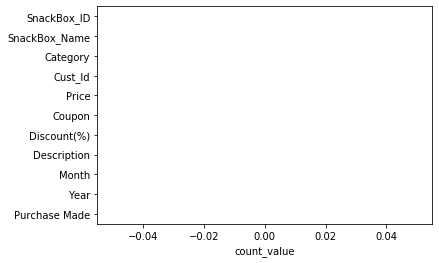

In [3]:
null_values = pd.DataFrame(df.isnull().sum(),columns=['count_value'])
ax = sns.barplot(null_values.count_value,null_values.index)

In [4]:
df['Description'].head(5)

0    Authentic snacks made by Japanese snack makers...
1     Love With Food is committed to healthy snacki...
2    Pure sugary fun! In every shipment, Candy Club...
3     All NatureBox snacks are minimally processed,...
4    Fun, healthy snacks! SnackNation guarantees th...
Name: Description, dtype: object

In [5]:
df.shape

(100, 11)

For any of you who has done even a bit of text processing before knows we need to convert the word vector of each overview. Now we'll compute Term Frequency-Inverse Document Frequency (TF-IDF) vectors for each overview.

Now if you are wondering what is term frequency , it is the relative frequency of a word in a document and is given as (term instances/total instances). Inverse Document Frequency is the relative count of documents containing the term is given as log(number of documents/documents with term) The overall importance of each word to the documents in which they appear is equal to TF * IDF

This will give you a matrix where each column represents a word in the overview vocabulary (all the words that appear in at least one document) and each column represents a movie, as before.This is done to reduce the importance of words that occur frequently in snackbox descriptions and therefore, their significance in computing the final similarity score.

Fortunately, scikit-learn gives you a built-in TfIdfVectorizer class that produces the TF-IDF matrix in a couple of lines. 

In [6]:
#Construct a reverse map of indices and movie titles

df_indices = df.drop_duplicates('SnackBox_Name', keep = "first")
indices = pd.Series(df_indices.index, index=df_indices['SnackBox_Name'])
len(indices)

15

In [7]:
#Import TfIdfVectorizer from scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

#Replace NaN with an empty string
df['Description'] = df['Description'].fillna('')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(df['Description'])

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(df_indices['Description'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape
# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix,tfidf_matrix)


We will be using the cosine similarity to calculate a numeric quantity that denotes the similarity between two movies. We use the cosine similarity score since it is independent of magnitude and is relatively easy and fast to calculate. Mathematically, it is defined as follows:
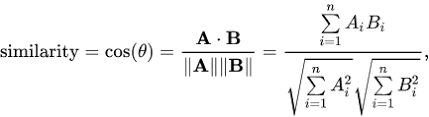


Since we have used the TF-IDF vectorizer, calculating the dot product will directly give us the cosine similarity score. Therefore, we will use sklearn's linear_kernel() instead of cosine_similarities() since it is faster.

In [8]:
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix,tfidf_matrix)

In [9]:
# indices

In [10]:
df[df['SnackBox_Name']=='ZenPop']

,SnackBox_ID,SnackBox_Name,Category,Cust_Id,Price,Coupon,Discount(%),Description,Month,Year,Purchase Made
5,104184,ZenPop,Japanese snack,C00151,24.50,Y,7,Sweet and savory Japanese snacks! ZenPop boxes...,Apr,2018,Y
32,104184,ZenPop,Japanese snack,C00148,24.50,Y,7,Sweet and savory Japanese snacks! ZenPop boxes...,May,2018,Y
60,104184,ZenPop,Japanese snack,C00151,24.50,Y,7,Sweet and savory Japanese snacks! ZenPop boxes...,Apr,2018,Y
90,104184,ZenPop,Japanese snack,C00145,24.50,Y,7,Sweet and savory Japanese snacks! ZenPop boxes...,May,2018,Y


We are now in a good position to define our recommendation function. These are the following steps we'll follow :-

* Get the index of the snackbox given its title.
* Get the list of cosine similarity scores for that particular snackbox name with all snackbox name. Convert it into a list of tuples where the first element is its position and the second is the similarity score.
* Sort the aforementioned list of tuples based on the similarity scores; that is, the second element.
* Get the top 10 elements of this list. Ignore the first element as it refers to self (the snackbox most similar to a particular snackbox is the snackbox itself).
* Return the titles corresponding to the indices of the top elements.

In [11]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(SnackBox_Name, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[SnackBox_Name]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1] , reverse=True)
    # sim_scores = sorted(sim_scores, reverse=True)
    
    # Get the scores of the 3 most similar movies
    sim_scores = sim_scores[1:5]

    # Get the movie indices
    product_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return df['SnackBox_Name'].iloc[product_indices]

In [12]:
get_recommendations('Candy Club')

4        SnackNation
13        TokyoTreat
11    Universal Yums
0             Snakku
Name: SnackBox_Name, dtype: object

In [13]:
# Visualization

In [14]:
import streamlit as st
import altair as alt
import sys

In [15]:
if sys.version_info[0] < 3:
    reload(sys)
    sys.setdefaultencoding("utf-8")

In [16]:
st.title('Snack Recommendations')
st.text('Select the snack from the dropdown')

In [17]:
column = st.selectbox("Which Similar Snacks you want to display?",df['SnackBox_Name'].unique())
st.write(get_recommendations(column))

In [18]:
df['Price'] = df['Price'].astype(float)
purchased = df[df['Purchase Made'] == 'Y']
purchased_group = purchased.groupby(['Cust_Id','Year','Month']).sum().reset_index()

In [19]:
purchased_group.head(5)

,Cust_Id,Year,Month,SnackBox_ID,Price,Discount(%)
0,C00145,2018,Dec,312573,45.00,10
1,C00145,2018,May,104184,24.50,7
2,C00145,2019,Apr,104185,9.95,0
3,C00146,2018,Jan,208358,77.90,20
4,C00146,2019,Jun,104187,39.00,6


In [20]:
st.title('Customer Trend')
st.text('Select the customerID from the dropdown')

In [21]:
customer = st.selectbox("Customer Buying Trend", purchased_group['Cust_Id'].unique())

In [29]:
data = pd.DataFrame({
    'index': purchased_group['Month'],
    'Total_Contribution': purchased_group['Price'].sum(),
}).set_index('index')

In [25]:
#st.write(data)
st.bar_chart(data)